In [1]:
import os, sys, math, random, copy
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, LeaveOneOut, StratifiedKFold
from sklearn.impute import SimpleImputer
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pandas as pd

from google.colab import drive

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


**Load preprocessed data**

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X_ad = np.load("/content/drive/MyDrive/67960_final_proj/X_ad.npy")
X_t2d = np.load("/content/drive/MyDrive/67960_final_proj/X_t2d.npy")
X_combined = np.load("/content/drive/MyDrive/67960_final_proj/X_combined.npy")
y_combined = np.load("/content/drive/MyDrive/67960_final_proj/y_combined.npy")

X_mouse = np.load("/content/drive/MyDrive/67960_final_proj/X_mouse.npy")
y_mouse = np.load("/content/drive/MyDrive/67960_final_proj/y_mouse.npy")

pathway_mask = np.load("/content/drive/MyDrive/67960_final_proj/pathway_mask.npy")
shared_genes = np.load("/content/drive/MyDrive/67960_final_proj/shared_genes.npy", allow_pickle=True)

**Model Definitions, Train Func, Helper Func, Eval Func**

In [5]:
# This will be used for the various masked autoencoders trained
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, mask=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        # Identity if no mask
        if mask is None:
            self.register_buffer('mask', torch.ones(out_features, in_features))
        else:
            self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32))
    def forward(self, x):
        # ensure mask is on same device as weights/input

        mask = self.mask.to(self.linear.weight.device)
         # column-wise masking: mask input features
        if mask.ndim == 1 and mask.shape[0] == self.linear.weight.shape[1]:
            w = self.linear.weight * mask.unsqueeze(0)
        # row-wise masking: mask output neurons
        elif mask.ndim == 1 and mask.shape[0] == self.linear.weight.shape[0]:
            w = self.linear.weight * mask.unsqueeze(1)
        else:
            w = self.linear.weight * mask  # must match exactly
        #w = self.linear.weight * mask
        return nn.functional.linear(x, w, self.linear.bias)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32, hidden_dims=[128], mask=None, soft_mask=False):
        super().__init__()
        # encoder: input -> hidden(s) -> latent
        enc_layers = []
        prev = input_dim
        # apply mask on first layer (pathway constraints apply between genes + latent rep, not needed for deeper inside NN)
        if len(hidden_dims)>0:
            # masked first layer -> hidden
            # mask must be (out_features, in_features) (nn.Linear weights are (out, in))
            enc_layers.append(MaskedLinear(prev, hidden_dims[0], mask=mask))
            enc_layers.append(nn.ReLU())
            for i in range(len(hidden_dims)-1):
                enc_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
                enc_layers.append(nn.ReLU())
            enc_layers.append(nn.Linear(hidden_dims[-1], latent_dim))
        else:
            #if no hidden layers, mask dir from input to latent
            enc_layers.append(MaskedLinear(prev, latent_dim, mask=mask))
        self.encoder = nn.Sequential(*enc_layers)
        # decoder: latent -> hidden (reverse) -> input
        dec_layers = []
        prev = latent_dim
        if len(hidden_dims)>0:
            dec_layers.append(nn.Linear(prev, hidden_dims[-1]))
            dec_layers.append(nn.ReLU())
            for i in range(len(hidden_dims)-1,0,-1):
                dec_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i-1]))
                dec_layers.append(nn.ReLU())
            dec_layers.append(nn.Linear(hidden_dims[0], input_dim))
        else:
            dec_layers.append(nn.Linear(prev, input_dim))
        self.decoder = nn.Sequential(*dec_layers)

        # save mask flag for regularization
        self.soft_mask = soft_mask
        # store mask tensor for regularization
        if mask is None:
            # default all ones with expected orientation: (out, in) where out = first hidden dim or latent
            first_out = hidden_dims[0] if len(hidden_dims)>0 else latent_dim
            self.register_buffer('mask_tensor', torch.ones((first_out, input_dim), dtype=torch.float32))
        else:
            m = torch.tensor(mask, dtype=torch.float32)
            # sanity check shape:
            first_out = hidden_dims[0] if len(hidden_dims)>0 else latent_dim
            assert m.shape == (first_out, input_dim), f"mask shape {m.shape} != expected {(first_out, input_dim)}"
            self.register_buffer('mask_tensor', m)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    def encode(self, x):
      if isinstance(x, np.ndarray):
          x = torch.from_numpy(x).float().to(next(self.parameters()).device)
      else:
          x = x.to(next(self.parameters()).device)
      return self.encoder(x)


In [7]:
# build a dummy mask for testing/debugging (will need actual pathway adjacencies later)
def build_dummy_mask(input_dim, hidden_dim, keep_fraction = 1.0):
  # No actual pathway dimensions, fill with ones (no masking) by default
  M = np.ones((hidden_dim, input_dim), dtype = np.float32)

  if keep_fraction < 1.0:
    # Mask portions of mask (based on fraction)
    # i.e. if keep_fraction = 0.8, mask 20%
    r_state = np.random.RandomState(0)
    mask_flat = r_state.rand(*M.shape)
    M = (mask_flat < keep_fraction).astype(np.float32)
  return M



In [8]:
# extract the model's latent representation from the autoencoder
def get_latents(model, X):
  model.eval()
  with torch.no_grad():
     X_t = torch.from_numpy(X).to(device).float()
     _, latents = model(X_t)
  return latents.cpu().numpy()


In [9]:
def recon_mse(model, X):
  model.eval()
  with torch.no_grad():
    X_t = torch.from_numpy(X).to(device).float()
    X_hat, _ = model(X_t)
    mse = nn.functional.mse_loss(X_hat, X_t, reduction='mean')
  return mse.item()

In [10]:
def print_umap(latent, y, title="UMAP"):
  reducer = UMAP(n_components=2, random_state=0)
  proj = reducer.fit_transform(latent)
  plt.figure(figsize=(8, 6))

  for lbl in np.unique(y):
    mask = (y==lbl)
    plt.scatter(proj[mask,0], proj[mask,1], label=str(lbl), s=8, alpha=0.8)
  plt.legend()
  plt.title(title)
  plt.show()

In [11]:
def train_ae(model, train_loader, val_loader=None, lr=1e-3, epochs=50, lambda_reg=0.0):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for ep in range(epochs):
        model.train()
        train_loss = 0.0
        cnt = 0

        for xb, _ in train_loader:
            xb = xb.to(device).float()
            opt.zero_grad()
            x_hat, _ = model(xb)

            # reconstruction loss
            loss = loss_fn(x_hat, xb)

            # soft-mask regularizer
            if lambda_reg > 0.0:
                reg_total = 0.0
                for module in model.modules():
                  if isinstance(module, MaskedLinear):
                      W = module.linear.weight
                      mask = module.mask   # <- THIS ONE
                      reg_total += ((1 - mask) * (W**2)).mean()


                loss = loss + lambda_reg * reg_total

            # backprop
            loss.backward()
            opt.step()

            train_loss += loss.item() * xb.size(0)
            cnt += xb.size(0)

        train_loss /= cnt
        if (ep+1) % 10 == 0 or ep==0:
            print(f"Epoch {ep+1}/{epochs} train_loss={train_loss:.6f}")

    return model


In [12]:
def cv_evaluation(
    model_class,
    X,
    n_splits=5,
    seeds=[0],
    mask=None,
    X_other=None,
    noise_std=0.1,
    lr=1e-3,
    epochs=60,
    batch_size=32,
    lambda_reg=None,
    **model_kwargs
):
    kf = KFold(n_splits=n_splits, shuffle=True)
    all_fold_results = []
    fold_models = []

    for seed in seeds:
        torch.manual_seed(seed)
        for train_idx, test_idx in kf.split(X):
            X_tr = X[train_idx]
            X_te = X[test_idx]

            model = model_class(**model_kwargs).to(device)

            # Setup DataLoader
            dummy_labels = torch.zeros(X_tr.shape[0], dtype=torch.long)
            train_loader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(torch.tensor(X_tr, dtype=torch.float32).to(device), dummy_labels.to(device)),
                batch_size=batch_size,
                shuffle=True
            )

            # Train the model
            if lambda_reg is not None:
                model = train_ae(model, train_loader, epochs=epochs, lr=lr, lambda_reg=lambda_reg)
            else:
                model = train_ae(model, train_loader, epochs=epochs, lr=lr)

            model_cpu = copy.deepcopy(model).cpu()
            fold_models.append(model_cpu)

            # Evaluate on test set
            X_te_tensor = torch.tensor(X_te, dtype=torch.float32).to(device)
            model.eval()
            with torch.no_grad():
                X_hat = model(X_te_tensor)[0]

                # Per-sample MSE
                sample_mse = nn.functional.mse_loss(X_hat, X_te_tensor, reduction='none').mean(dim=1).cpu().numpy()

                # Per-gene MSE
                gene_mse = nn.functional.mse_loss(X_hat, X_te_tensor, reduction='none').mean(dim=0).cpu().numpy()

                # Per-pathway MSE
                if mask is not None:
                    X_hat_np = X_hat.cpu().numpy()
                    pathway_mse = []
                    for i in range(mask.shape[0]):
                        pathway_genes = mask[i] == 1
                        if pathway_genes.sum() > 0:
                            pathway_mse.append(np.mean((X_hat_np[:, pathway_genes] - X_te[:, pathway_genes])**2))
                        else:
                            pathway_mse.append(np.nan)
                else:
                    pathway_mse = None

                # Noise robustness
                X_noisy = X_te + noise_std * np.random.randn(*X_te.shape)
                X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
                robustness_mse = nn.functional.mse_loss(model(X_noisy_tensor)[0], X_hat).item()

                # Cross-dataset MSE
                cross_mse = recon_mse(model, X_other) if X_other is not None else None

            all_fold_results.append({
                'sample_mse': sample_mse,
                'gene_mse': gene_mse,
                'pathway_mse': pathway_mse,
                'robustness_mse': robustness_mse,
                'cross_mse': cross_mse
            })

    return all_fold_results, fold_models


In [13]:
def cv_eval(cv_results, mask=False):
  # Example: mean ± std of per-fold sample MSE
  all_sample_mse = np.concatenate([r['sample_mse'] for r in cv_results])
  print("Mean sample MSE:", all_sample_mse.mean())
  print("Std sample MSE:", all_sample_mse.std())

  # Mean per-gene MSE
  all_gene_mse = np.stack([r['gene_mse'] for r in cv_results])
  print("Mean per-gene MSE:", all_gene_mse.mean(axis=0))

  # Mean noise robustness
  robustness_mse = [r['robustness_mse'] for r in cv_results]
  print("Mean robustness MSE:", np.mean(robustness_mse))

  # Cross-dataset MSE
  cross_mse = [r['cross_mse'] for r in cv_results if r['cross_mse'] is not None]
  if cross_mse:  # check that the list is not empty
      print("Mean cross-dataset MSE:", np.mean(cross_mse))
  else:
      print("No cross-dataset MSE values available.")

  if mask:
      all_pathway_mse = np.stack([r['pathway_mse'] for r in cv_results])
      print("Mean per-pathway MSE:", np.nanmean(all_pathway_mse, axis=0))

In [14]:
from scipy.spatial.distance import cdist
def dg_test(model_train, X_train, model_test, X_test, metric='cosine', device=device):
    # Get latent embeddings
    with torch.no_grad():
        z_train = model_train.encode(torch.tensor(X_train).float().to(device)).cpu().numpy()
        z_test  = model_test.encode(torch.tensor(X_test).float().to(device)).cpu().numpy()

    # Compute source latent mean
    z_mean = z_train.mean(axis=0, keepdims=True)  # shape (1, latent_dim)

    # Compute similarity of each target latent to source mean
    if metric == 'cosine':
        # cosine similarity = 1 - cosine distance
        sim_scores = 1 - cdist(z_test, z_mean, metric='cosine').flatten()
    elif metric == 'euclidean':
        # convert distance to similarity
        dist = cdist(z_test, z_mean, metric='euclidean').flatten()
        sim_scores = np.exp(-dist)  # higher = closer
    else:
        raise ValueError(f"Unknown metric {metric}")

    mean_similarity = sim_scores.mean()
    return mean_similarity, sim_scores

In [15]:
from sklearn.manifold import trustworthiness as skl_trust

def latent_trustworthiness(model, X, n_neighbors=10):
    Z = model.encode(torch.tensor(X).float()).detach().numpy()
    return skl_trust(X, Z, n_neighbors=n_neighbors)


# **Human (GSE15222, AD and GSE38642, T2D) Testing**

**Step 1: Prepare data for AE**

Will be training and evaluating AE on the AD and T2D datasets separately

In [16]:
# Keep gene order
genes = list(shared_genes)

imputer = SimpleImputer(strategy='mean')
X_all_imputed = imputer.fit_transform(X_combined)

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_imputed)

X_ad_scaled  = X_all_scaled[:X_ad.shape[0], :]
X_t2d_scaled = X_all_scaled[X_ad.shape[0]:, :]

In [17]:
X_ad_tr, X_ad_te = train_test_split(X_ad_scaled, test_size=0.2, random_state=42)
X_t2d_tr, X_t2d_te = train_test_split(X_t2d_scaled, test_size=0.2, random_state=42)

In [18]:
assert not np.isnan(X_ad_tr).any()
assert not np.isinf(X_ad_tr).any()

In [19]:
batch_size = 32

# AD dataset
ad_tr_tensor = torch.tensor(X_ad_tr, dtype=torch.float32)
dummy_labels_ad = torch.zeros(ad_tr_tensor.shape[0], dtype=torch.long)
ad_train_ds = TensorDataset(ad_tr_tensor, dummy_labels_ad)
ad_train_loader = DataLoader(ad_train_ds, batch_size=batch_size, shuffle=True)

# T2D dataset
t2d_tr_tensor = torch.tensor(X_t2d_tr, dtype=torch.float32)
dummy_labels_t2d = torch.zeros(t2d_tr_tensor.shape[0], dtype=torch.long)
t2d_train_ds = TensorDataset(t2d_tr_tensor, dummy_labels_t2d)
t2d_train_loader = DataLoader(t2d_train_ds, batch_size=batch_size, shuffle=True)

In [20]:
assert not np.isnan(X_all_scaled).any()
assert X_all_scaled.shape[0] == len(y_combined)
assert set(np.unique(y_combined)) == {0,1}
print("Final shape:", X_all_scaled.shape)

Final shape: (426, 14666)


In [21]:
print("Mean ~0:", X_all_scaled.mean(), "Std ~1:", X_all_scaled.std())

Mean ~0: -9.54023e-11 Std ~1: 0.9999999


In [22]:
X_combined_tr, X_combined_te = train_test_split(X_all_scaled, test_size=0.2, random_state=42)
y_combined_tr, y_combined_te = train_test_split(y_combined, test_size=0.2, random_state=42)

In [23]:
batch_size = 32

combined_tr_tensor = torch.tensor(X_combined_tr, dtype=torch.float32)
dummy_labels = torch.zeros(X_combined_tr.shape[0], dtype=torch.long)
combined_train_ds = TensorDataset(combined_tr_tensor, dummy_labels)
combined_train_loader = DataLoader(combined_train_ds, batch_size=batch_size, shuffle=True)

# **Testing on CV-trained AEs**

In [16]:
assert not np.isnan(X_all_scaled).any()
assert X_all_scaled.shape[0] == len(y_combined)
assert set(np.unique(y_combined)) == {0,1}
print("Final shape:", X_all_scaled.shape)

Final shape: (426, 14666)


In [17]:
print("Mean ~0:", X_all_scaled.mean(), "Std ~1:", X_all_scaled.std())

Mean ~0: -9.54023e-11 Std ~1: 0.9999999


In [18]:
X_combined_tr, X_combined_te = train_test_split(X_all_scaled, test_size=0.2, random_state=42)
y_combined_tr, y_combined_te = train_test_split(y_combined, test_size=0.2, random_state=42)

In [19]:
batch_size = 32

combined_tr_tensor = torch.tensor(X_combined_tr, dtype=torch.float32)
dummy_labels = torch.zeros(X_combined_tr.shape[0], dtype=torch.long)
combined_train_ds = TensorDataset(combined_tr_tensor, dummy_labels)
combined_train_loader = DataLoader(combined_train_ds, batch_size=batch_size, shuffle=True)

# **Load CV-trained DS**

In [24]:
hidden_dims=[pathway_mask.shape[0]]
input_dim=X_combined_tr.shape[1]
latent_dim=64

In [25]:
data = torch.load('/content/drive/MyDrive/67960_final_proj/soft_combined_ae.pt', map_location='cpu', weights_only=False)

soft_combined_metrics = data['metrics']
soft_combined_models_state = data['models']

soft_combined_models = []
for sd in soft_combined_models_state:
  model = Autoencoder(
      input_dim=X_combined_tr.shape[1],
      latent_dim=96,
      hidden_dims=[pathway_mask.shape[0]],
      mask=pathway_mask, soft_mask=True
  )
  model.load_state_dict(sd)
  model.eval()
  soft_combined_models.append(model)


In [26]:
data = torch.load('/content/drive/MyDrive/67960_final_proj/hard_combined_ae.pt', map_location='cpu', weights_only=False)

hard_combined_metrics = data['metrics']
hard_combined_models_state = data['models']

hard_combined_models = []
for sd in hard_combined_models_state:
  model = Autoencoder(
      input_dim=X_combined_tr.shape[1],
      latent_dim=96,
      hidden_dims=[pathway_mask.shape[0]],
      mask=pathway_mask, soft_mask=False
  )
  model.load_state_dict(sd)
  model.eval()
  hard_combined_models.append(model)


In [27]:
hidden_dims=[pathway_mask.shape[0]]
input_dim=X_combined_tr.shape[1]
latent_dim=64

mask_none = np.ones((hidden_dims[0], input_dim), dtype=np.float32)
data = torch.load('/content/drive/MyDrive/67960_final_proj/baseline_combined_ae.pt', map_location='cpu', weights_only=False)

baseline_combined_metrics = data['metrics']
baseline_combined_models_state = data['models']

baseline_combined_models = []
for sd in baseline_combined_models_state:
  model = Autoencoder(
      input_dim=input_dim,
      latent_dim=96,
      hidden_dims=hidden_dims,
      mask=mask_none, soft_mask=False
  )
  model.load_state_dict(sd)
  model.eval()
  baseline_combined_models.append(model)


In [28]:
data = torch.load('/content/drive/MyDrive/67960_final_proj/soft_ad_specific_ae.pt', map_location='cpu', weights_only=False)

soft_ad_metrics = data['metrics']
soft_ad_models_state = data['models']

soft_ad_models = []
for sd in soft_ad_models_state:
  model = Autoencoder(
      input_dim=X_combined_tr.shape[1],
      latent_dim=64,
      hidden_dims=[pathway_mask.shape[0]],
      mask=pathway_mask, soft_mask=True
  )
  model.load_state_dict(sd)
  model.eval()
  soft_ad_models.append(model)


In [29]:
data = torch.load('/content/drive/MyDrive/67960_final_proj/hard_ad_specific_ae.pt', map_location='cpu', weights_only=False)

hard_ad_metrics = data['metrics']
hard_ad_models_state = data['models']

hard_ad_models = []
for sd in hard_ad_models_state:
  model = Autoencoder(
      input_dim=X_combined_tr.shape[1],
      latent_dim=64,
      hidden_dims=[pathway_mask.shape[0]],
      mask=pathway_mask, soft_mask=False
  )
  model.load_state_dict(sd)
  model.eval()
  hard_ad_models.append(model)


In [30]:
hidden_dims=[pathway_mask.shape[0]]
input_dim=X_combined_tr.shape[1]
latent_dim=64

mask_none = np.ones((hidden_dims[0], input_dim), dtype=np.float32)
data = torch.load('/content/drive/MyDrive/67960_final_proj/baseline_ad_specific_ae.pt', map_location='cpu', weights_only=False)

baseline_ad_metrics = data['metrics']
baseline_ad_models_state = data['models']

baseline_ad_models = []
for sd in baseline_ad_models_state:
  model = Autoencoder(
      input_dim=input_dim,
      latent_dim=latent_dim,
      hidden_dims=hidden_dims,
      mask=mask_none, soft_mask=False
  )
  model.load_state_dict(sd)
  model.eval()
  baseline_ad_models.append(model)


In [31]:
data = torch.load('/content/drive/MyDrive/67960_final_proj/soft_t2d_specific_ae.pt', map_location='cpu', weights_only=False)

soft_t2d_metrics = data['metrics']
soft_t2d_models_state = data['models']

soft_t2d_models = []
for sd in soft_t2d_models_state:
  model = Autoencoder(
      input_dim=X_combined_tr.shape[1],
      latent_dim=64,
      hidden_dims=[pathway_mask.shape[0]],
      mask=pathway_mask, soft_mask=True
  )
  model.load_state_dict(sd)
  model.eval()
  soft_t2d_models.append(model)


In [32]:
data = torch.load('/content/drive/MyDrive/67960_final_proj/hard_t2d_specific_ae.pt', map_location='cpu', weights_only=False)

hard_t2d_metrics = data['metrics']
hard_t2d_models_state = data['models']

hard_t2d_models = []
for sd in hard_t2d_models_state:
  model = Autoencoder(
      input_dim=X_combined_tr.shape[1],
      latent_dim=64,
      hidden_dims=[pathway_mask.shape[0]],
      mask=pathway_mask, soft_mask=False
  )
  model.load_state_dict(sd)
  model.eval()
  hard_t2d_models.append(model)


In [33]:
hidden_dims=[pathway_mask.shape[0]]
input_dim=X_combined_tr.shape[1]
latent_dim=64

mask_none = np.ones((hidden_dims[0], input_dim), dtype=np.float32)
data = torch.load('/content/drive/MyDrive/67960_final_proj/baseline_t2d_specific_ae.pt', map_location='cpu', weights_only=False)

baseline_t2d_metrics = data['metrics']
baseline_t2d_models_state = data['models']

baseline_t2d_models = []
for sd in baseline_t2d_models_state:
  model = Autoencoder(
      input_dim=input_dim,
      latent_dim=latent_dim,
      hidden_dims=hidden_dims,
      mask=mask_none, soft_mask=False
  )
  model.load_state_dict(sd)
  model.eval()
  baseline_t2d_models.append(model)


# Testing Locality/Geometry symmetry

In [34]:
# For AE trained on AD only
trust_scores_soft_ad = []
for model in soft_ad_models:
  trust = latent_trustworthiness(model, X_t2d_scaled)
  trust_scores_soft_ad.append(trust)

trust_scores_hard_ad = []
for model in hard_ad_models:
  trust = latent_trustworthiness(model, X_t2d_scaled)
  trust_scores_hard_ad.append(trust)


trust_scores_baseline_ad = []
for model in baseline_ad_models:
  trust = latent_trustworthiness(model, X_t2d_scaled)
  trust_scores_baseline_ad.append(trust)

In [35]:
# For AE trained on T2D only
trust_scores_soft_t2d = []
for model in soft_t2d_models:
  trust = latent_trustworthiness(model, X_t2d_scaled)
  trust_scores_soft_t2d.append(trust)

trust_scores_hard_ad = []
for model in hard_ad_models:
  trust = latent_trustworthiness(model, X_t2d_scaled)
  trust_scores_hard_ad.append(trust)


trust_scores_baseline_ad = []
for model in baseline_ad_models:
  trust = latent_trustworthiness(model, X_t2d_scaled)
  trust_scores_baseline_ad.append(trust)

In [36]:
from scipy.spatial.distance import cdist

def dg_cosine_mean_similarity(model_train, X_train, model_test, X_test, device=device):
    model_train = model_train.to(device); model_train.eval()
    model_test = model_test.to(device); model_test.eval()
    with torch.no_grad():
        z_train = model_train.encode(torch.tensor(X_train).float().to(device)).cpu().numpy()
        z_test  = model_test.encode(torch.tensor(X_test).float().to(device)).cpu().numpy()
    z_mean = z_train.mean(axis=0, keepdims=True)
    sim_scores = 1 - cdist(z_test, z_mean, metric='cosine').flatten()
    return sim_scores.mean(), sim_scores  # mean similarity + vector

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def dg_classification_auc(model_train, X_train, model_test, X_test, device=device):
    # encode both domains
    model_train = model_train.to(device); model_train.eval()
    model_test = model_test.to(device); model_test.eval()
    with torch.no_grad():
        z_train = model_train.encode(torch.tensor(X_train).float().to(device)).cpu().numpy()
        z_test  = model_test.encode(torch.tensor(X_test).float().to(device)).cpu().numpy()

    # train on full source + half the target, test on the other half of target
    n_test = z_test.shape[0]//2
    if n_test == 0:
        # too small to split; just compute mean similarity instead
        return np.nan

    z_target_train = z_test[:len(z_test)-n_test]
    z_target_hold  = z_test[len(z_test)-n_test:]

    X_clf_train = np.vstack([z_train, z_target_train])
    y_clf_train = np.array([0]*len(z_train) + [1]*len(z_target_train))
    X_clf_test  = z_target_hold
    y_clf_test  = np.ones(len(z_target_hold))

    clf = LogisticRegression(max_iter=2000, solver='liblinear')
    clf.fit(X_clf_train, y_clf_train)

    y_prob = clf.predict_proba(X_clf_test)[:, 1]
    auc = roc_auc_score(y_clf_test, y_prob)
    return auc


In [38]:
def evaluate_model_set(models, train_X, test_X):
    dg_cos_means = []
    dg_auc_list  = []
    trust_scores = []
    cross_mses   = []

    for m in models:
        m = m.to(device); m.eval()

        # cross-dataset reconstruction MSE
        cross_mses.append(recon_mse(m, test_X))

        # DG cosine
        mean_sim, sim_scores = dg_cosine_mean_similarity(m, train_X, m, test_X)
        dg_cos_means.append(mean_sim)

        # DG classifier AUC
        try:
            auc = dg_classification_auc(m, train_X, m, test_X)
        except Exception:
            auc = np.nan
        dg_auc_list.append(auc)

        # trustworthiness on train domain
        try:
            trust = latent_trustworthiness(m, train_X)
        except Exception:
            trust = np.nan
        trust_scores.append(trust)

    return {
        'cross_mse_mean': np.nanmean(cross_mses),
        'cross_mse_std': np.nanstd(cross_mses),
        'dg_cos_mean': np.nanmean(dg_cos_means),
        'dg_cos_std': np.nanstd(dg_cos_means),
        'dg_auc_mean': np.nanmean(dg_auc_list),
        'dg_auc_std': np.nanstd(dg_auc_list),
        'trust_mean': np.nanmean(trust_scores),
        'trust_std': np.nanstd(trust_scores)
    }

In [39]:
soft_t2d_models_within = evaluate_model_set(soft_t2d_models, X_t2d_scaled, X_t2d_scaled)
soft_t2d_models_ad_to_t2d  = evaluate_model_set(soft_t2d_models, X_t2d_scaled, X_ad_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

In [40]:
print(soft_t2d_models_within)
print(soft_t2d_models_ad_to_t2d)

{'cross_mse_mean': np.float64(0.6757739623387654), 'cross_mse_std': np.float64(0.031513634580898627), 'dg_cos_mean': np.float64(0.18406661963348434), 'dg_cos_std': np.float64(0.022439045180309793), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.941364522417154), 'trust_std': np.float64(0.00989833700627855)}
{'cross_mse_mean': np.float64(0.7248359123865763), 'cross_mse_std': np.float64(0.0011731115063840897), 'dg_cos_mean': np.float64(0.20808232773257845), 'dg_cos_std': np.float64(0.03497651060838795), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.941364522417154), 'trust_std': np.float64(0.00989833700627855)}


In [41]:
hard_t2d_models_within = evaluate_model_set(hard_t2d_models, X_t2d_scaled, X_t2d_scaled)
hard_t2d_models_ad_to_t2d  = evaluate_model_set(hard_t2d_models, X_t2d_scaled, X_ad_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

In [42]:
print(hard_t2d_models_within)
print(hard_t2d_models_ad_to_t2d)

{'cross_mse_mean': np.float64(0.6779154698053996), 'cross_mse_std': np.float64(0.03362324551419907), 'dg_cos_mean': np.float64(0.1904815596609246), 'dg_cos_std': np.float64(0.02408803131048099), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.9409635199108882), 'trust_std': np.float64(0.014881129961598861)}
{'cross_mse_mean': np.float64(0.7247168103853862), 'cross_mse_std': np.float64(0.001156751395744427), 'dg_cos_mean': np.float64(0.22038494427701374), 'dg_cos_std': np.float64(0.04157716941477899), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.9409635199108882), 'trust_std': np.float64(0.014881129961598861)}


In [43]:
baseline_t2d_models_within = evaluate_model_set(baseline_t2d_models, X_t2d_scaled, X_t2d_scaled)
baseline_t2d_models_ad_to_t2d  = evaluate_model_set(baseline_t2d_models, X_t2d_scaled, X_ad_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

In [44]:
print(baseline_t2d_models_within)
print(baseline_t2d_models_ad_to_t2d)

{'cross_mse_mean': np.float64(0.5274958391984303), 'cross_mse_std': np.float64(0.03132053636575113), 'dg_cos_mean': np.float64(0.25316795478981885), 'dg_cos_std': np.float64(0.03785847943091767), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.9349729880256198), 'trust_std': np.float64(0.00988891466912484)}
{'cross_mse_mean': np.float64(0.727200969060262), 'cross_mse_std': np.float64(0.0017011278283229452), 'dg_cos_mean': np.float64(0.28279164338255336), 'dg_cos_std': np.float64(0.05933151810326639), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.9349729880256198), 'trust_std': np.float64(0.00988891466912484)}


In [45]:
soft_ad_models_within = evaluate_model_set(soft_ad_models, X_ad_scaled, X_ad_scaled)
soft_ad_models_ad_to_t2d  = evaluate_model_set(soft_ad_models, X_ad_scaled, X_t2d_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

In [46]:
print(soft_ad_models_within)
print(soft_ad_models_ad_to_t2d)

{'cross_mse_mean': np.float64(0.19938479363918304), 'cross_mse_std': np.float64(0.007550570909431884), 'dg_cos_mean': np.float64(0.32962974257844807), 'dg_cos_std': np.float64(0.05748202545559619), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.9894445831764341), 'trust_std': np.float64(0.0012435752672914524)}
{'cross_mse_mean': np.float64(2.5340246200561523), 'cross_mse_std': np.float64(0.001549374105855358), 'dg_cos_mean': np.float64(0.31319279050081505), 'dg_cos_std': np.float64(0.057483930326509405), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.9894445831764341), 'trust_std': np.float64(0.0012435752672914524)}


In [47]:
hard_ad_models_within = evaluate_model_set(hard_ad_models, X_ad_scaled, X_ad_scaled)
hard_ad_models_ad_to_t2d  = evaluate_model_set(hard_ad_models, X_ad_scaled, X_t2d_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

In [48]:
print(hard_ad_models_within)
print(hard_ad_models_ad_to_t2d)

{'cross_mse_mean': np.float64(0.20228702028592427), 'cross_mse_std': np.float64(0.010551237861750306), 'dg_cos_mean': np.float64(0.3223923173458186), 'dg_cos_std': np.float64(0.03711928624650601), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.9894791472607037), 'trust_std': np.float64(0.0013824000060903103)}
{'cross_mse_mean': np.float64(2.5340523878733316), 'cross_mse_std': np.float64(0.0016183145686566565), 'dg_cos_mean': np.float64(0.316233256318332), 'dg_cos_std': np.float64(0.0465787292384928), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.9894791472607037), 'trust_std': np.float64(0.0013824000060903103)}


In [49]:
baseline_ad_models_within = evaluate_model_set(baseline_ad_models, X_ad_scaled, X_ad_scaled)
baseline_ad_models_ad_to_t2d  = evaluate_model_set(baseline_ad_models, X_ad_scaled, X_t2d_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

In [50]:
print(baseline_ad_models_within)
print(baseline_ad_models_ad_to_t2d)

{'cross_mse_mean': np.float64(0.20068962772687277), 'cross_mse_std': np.float64(0.010312746206268727), 'dg_cos_mean': np.float64(0.33044649091599065), 'dg_cos_std': np.float64(0.03319523483070687), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.989455681735603), 'trust_std': np.float64(0.0012221729482908886)}
{'cross_mse_mean': np.float64(2.533803145090739), 'cross_mse_std': np.float64(0.001237501678796871), 'dg_cos_mean': np.float64(0.3162126882153143), 'dg_cos_std': np.float64(0.03737043673964635), 'dg_auc_mean': np.float64(nan), 'dg_auc_std': np.float64(nan), 'trust_mean': np.float64(0.989455681735603), 'trust_std': np.float64(0.0012221729482908886)}


**Latent Classification AUC**

In [54]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import torch

def latent_classification_auc(models, X, y, n_splits=5, random_state=42):
    all_models_auc_scores = []

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

    for model in models:
        model.eval()
        with torch.no_grad():
            latent_features = model.encode(X_tensor).cpu().numpy()

        fold_auc_scores = []
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for train_index, test_index in skf.split(latent_features, y):
            X_train_fold, X_test_fold = latent_features[train_index], latent_features[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            # Both classes in training and test folds
            if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_test_fold)) < 2:
                # Skip this fold (can't do AUC on single-dim)
                continue

            clf = LogisticRegression(max_iter=2000, solver='liblinear', random_state=random_state)
            clf.fit(X_train_fold, y_train_fold)
            y_prob = clf.predict_proba(X_test_fold)[:, 1]
            auc = roc_auc_score(y_test_fold, y_prob)
            fold_auc_scores.append(auc)

        if fold_auc_scores:
            all_models_auc_scores.append(np.mean(fold_auc_scores))
        else:
            all_models_auc_scores.append(np.nan)

    return np.array(all_models_auc_scores)

In [55]:
y_ad = y_combined[:X_ad.shape[0]]
y_t2d = y_combined[X_ad.shape[0]:]

# Evaluate Combined Data AE
print("Evaluating Combined Models for AD vs T2D classification:")
auc_soft_combined = latent_classification_auc(soft_combined_models, X_all_scaled, y_combined)
auc_hard_combined = latent_classification_auc(hard_combined_models, X_all_scaled, y_combined)
auc_baseline_combined = latent_classification_auc(baseline_combined_models, X_all_scaled, y_combined)

print(f"Soft Combined Models AUC: Mean={np.nanmean(auc_soft_combined):.4f}, Std={np.nanstd(auc_soft_combined):.4f}")
print(f"Hard Combined Models AUC: Mean={np.nanmean(auc_hard_combined):.4f}, Std={np.nanstd(auc_hard_combined):.4f}")
print(f"Baseline Combined Models AUC: Mean={np.nanmean(auc_baseline_combined):.4f}, Std={np.nanstd(auc_baseline_combined):.4f}")
print("-" * 50)

# Evaluate AD-Specific AE
# Check if y_ad contains at least two classes to compute AUC
print("Evaluating AD-Specific Models for classification within AD dataset:")
if len(np.unique(y_ad)) > 1:
    auc_soft_ad = latent_classification_auc(soft_ad_models, X_ad_scaled, y_ad)
    auc_hard_ad = latent_classification_auc(hard_ad_models, X_ad_scaled, y_ad)
    auc_baseline_ad = latent_classification_auc(baseline_ad_models, X_ad_scaled, y_ad)

    print(f"Soft AD Models AUC: Mean={np.nanmean(auc_soft_ad):.4f}, Std={np.nanstd(auc_soft_ad):.4f}")
    print(f"Hard AD Models AUC: Mean={np.nanmean(auc_hard_ad):.4f}, Std={np.nanstd(auc_hard_ad):.4f}")
    print(f"Baseline AD Models AUC: Mean={np.nanmean(auc_baseline_ad):.4f}, Std={np.nanstd(auc_baseline_ad):.4f}")
else:
    print("Skipping AD-specific classification: y_ad contains only one unique class.")
print("-" * 50)

# Evaluate T2D-Specific AE
print("Evaluating T2D-Specific Models for classification within T2D dataset:")
if len(np.unique(y_t2d)) > 1:
    auc_soft_t2d = latent_classification_auc(soft_t2d_models, X_t2d_scaled, y_t2d)
    auc_hard_t2d = latent_classification_auc(hard_t2d_models, X_t2d_scaled, y_t2d)
    auc_baseline_t2d = latent_classification_auc(baseline_t2d_models, X_t2d_scaled, y_t2d)

    print(f"Soft T2D Models AUC: Mean={np.nanmean(auc_soft_t2d):.4f}, Std={np.nanstd(auc_soft_t2d):.4f}")
    print(f"Hard T2D Models AUC: Mean={np.nanmean(auc_hard_t2d):.4f}, Std={np.nanstd(auc_hard_t2d):.4f}")
    print(f"Baseline T2D Models AUC: Mean={np.nanmean(auc_baseline_t2d):.4f}, Std={np.nanstd(auc_baseline_t2d):.4f}")
else:
    print("Skipping T2D-specific classification: y_t2d contains only one unique class.")
print("-" * 50)

print("Disease classification AUC evaluation complete.")


Evaluating Combined Models for AD vs T2D classification:
Soft Combined Models AUC: Mean=0.7614, Std=0.0503
Hard Combined Models AUC: Mean=0.9021, Std=0.0290
Baseline Combined Models AUC: Mean=0.9016, Std=0.0374
--------------------------------------------------
Evaluating AD-Specific Models for classification within AD dataset:
Skipping AD-specific classification: y_ad contains only one unique class.
--------------------------------------------------
Evaluating T2D-Specific Models for classification within T2D dataset:
Skipping T2D-specific classification: y_t2d contains only one unique class.
--------------------------------------------------
Disease classification AUC evaluation complete.


**Latent AUC with permutation**



In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import torch

def latent_auc_with_permutation(
    models, X, y, n_splits=5, n_permutations=100, random_state=42
):
    all_models_observed_aucs = []
    all_models_p_values = []

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

    for idx, model in enumerate(models):
        model.eval()
        model.to(device)

        with torch.no_grad():
            latent_features = model.encode(X_tensor).cpu().numpy()

        observed_auc_folds = []
        all_permuted_aucs_for_model = []

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for fold_idx, (train_index, test_index) in enumerate(skf.split(latent_features, y)):
            X_train_fold, X_test_fold = latent_features[train_index], latent_features[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            # Check if both classes are present in training and testing folds
            if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_test_fold)) < 2:
                continue

            # Calculate observed AUC for the fold
            clf_observed = LogisticRegression(max_iter=2000, solver='liblinear', random_state=random_state)
            clf_observed.fit(X_train_fold, y_train_fold)
            y_pred_proba_observed = clf_observed.predict_proba(X_test_fold)[:, 1]
            auc_observed = roc_auc_score(y_test_fold, y_pred_proba_observed)
            observed_auc_folds.append(auc_observed)

            # Permutation Testing for the fold
            for perm_idx in range(n_permutations):
                # Shuffle y_train_fold labels
                rng = np.random.RandomState(random_state + perm_idx)
                y_train_fold_permuted = rng.permutation(y_train_fold)

                clf_permuted = LogisticRegression(max_iter=2000, solver='liblinear', random_state=random_state)
                clf_permuted.fit(X_train_fold, y_train_fold_permuted)
                y_pred_proba_permuted = clf_permuted.predict_proba(X_test_fold)[:, 1]

                # Use original y_test_fold for evaluation of permuted models
                auc_permuted = roc_auc_score(y_test_fold, y_pred_proba_permuted)
                all_permuted_aucs_for_model.append(auc_permuted)

        if observed_auc_folds:
            mean_observed_auc = np.mean(observed_auc_folds)
            all_models_observed_aucs.append(mean_observed_auc)

            # Calculate permutation p-value for the current model
            if all_permuted_aucs_for_model:
                count_better_than_observed = np.sum(np.array(all_permuted_aucs_for_model) >= mean_observed_auc)
                p_value = (count_better_than_observed + 1) / (len(all_permuted_aucs_for_model) + 1)
                all_models_p_values.append(p_value)
            else:
                all_models_p_values.append(np.nan)
        else:
            all_models_observed_aucs.append(np.nan)
            all_models_p_values.append(np.nan)

    return np.array(all_models_observed_aucs), np.array(all_models_p_values)


In [64]:
print("Evaluating Combined Models for AD vs T2D classification with permutation testing:")
n_permutations = 100

# Soft Combined Models
auc_soft_combined_perm, p_soft_combined = latent_auc_with_permutation(
    soft_combined_models, X_all_scaled, y_combined, n_permutations=n_permutations
)
print(f"Soft Combined Models AUC: Mean={np.nanmean(auc_soft_combined_perm):.4f}, Std={np.nanstd(auc_soft_combined_perm):.4f}, Mean P-value={np.nanmean(p_soft_combined):.4f}")

# Hard Combined Models
auc_hard_combined_perm, p_hard_combined = latent_auc_with_permutation(
    hard_combined_models, X_all_scaled, y_combined, n_permutations=n_permutations
)
print(f"Hard Combined Models AUC: Mean={np.nanmean(auc_hard_combined_perm):.4f}, Std={np.nanstd(auc_hard_combined_perm):.4f}, Mean P-value={np.nanmean(p_hard_combined):.4f}")

# Baseline Combined Models
auc_baseline_combined_perm, p_baseline_combined = latent_auc_with_permutation(
    baseline_combined_models, X_all_scaled, y_combined, n_permutations=n_permutations
)
print(f"Baseline Combined Models AUC: Mean={np.nanmean(auc_baseline_combined_perm):.4f}, Std={np.nanstd(auc_baseline_combined_perm):.4f}, Mean P-value={np.nanmean(p_baseline_combined):.4f}")
print("-" * 50)

print("Permutation-based AUC evaluation complete for combined models.")

Evaluating Combined Models for AD vs T2D classification with permutation testing:
Soft Combined Models AUC: Mean=0.7614, Std=0.0503, Mean P-value=0.0177
Hard Combined Models AUC: Mean=0.9021, Std=0.0290, Mean P-value=0.0021
Baseline Combined Models AUC: Mean=0.9016, Std=0.0374, Mean P-value=0.0023
--------------------------------------------------
Permutation-based AUC evaluation complete for combined models.


**Pathway Interpetability**

In [34]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

def pathway_interpretability(
    models, X, pathway_mask, alpha=0.05, top_n_examples=5, device='cpu'
):
    """
    Evaluate how well latent features align with biological pathways.

    Returns:
        model_significant_alignments: list of int, counts of significant latent-pathway correlations
        model_top_examples: list of list of dicts, top correlations per model
        model_all_correlations: list of arrays, all correlations per model
    """
    X_tensor = torch.from_numpy(X).float().to(device)

    # Calculate pathway activity scores
    pathway_activity_scores = np.zeros((X.shape[0], pathway_mask.shape[0]))
    pathway_names = [f'Pathway_{i}' for i in range(pathway_mask.shape[0])]

    for i in range(pathway_mask.shape[0]):
        genes_idx = np.where(pathway_mask[i, :] == 1)[0]
        if len(genes_idx) > 0:
            pathway_activity_scores[:, i] = X[:, genes_idx].mean(axis=1)
        else:
            pathway_activity_scores[:, i] = np.nan

    model_significant_alignments = []
    model_top_examples = []
    model_all_correlations = []

    for model in models:
        model.eval()
        model.to(device)
        with torch.no_grad():
            latent_features = model.encode(X_tensor).cpu().numpy()

        correlations, p_values = [], []
        latent_indices, pathway_indices_list = [], []

        for lf_idx in range(latent_features.shape[1]):
            for p_idx in range(pathway_activity_scores.shape[1]):
                if np.all(np.isnan(pathway_activity_scores[:, p_idx])):
                    continue
                corr, pval = spearmanr(latent_features[:, lf_idx],
                                       pathway_activity_scores[:, p_idx],
                                       nan_policy='omit')
                correlations.append(corr)
                p_values.append(pval)
                latent_indices.append(lf_idx)
                pathway_indices_list.append(p_idx)

        correlations = np.array(correlations)
        p_values = np.array(p_values)
        model_all_correlations.append(correlations)

        if len(p_values) > 0:
            reject, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
        else:
            reject = np.array([])
            pvals_corrected = np.array([])

        model_significant_alignments.append(np.sum(reject))

        # Top significant alignments
        significant_alignments = [
            {'latent_feature_idx': latent_indices[i],
             'pathway_name': pathway_names[pathway_indices_list[i]],
             'correlation': correlations[i],
             'p_value_corrected': pvals_corrected[i]}
            for i in range(len(reject)) if reject[i]
        ]
        significant_alignments_sorted = sorted(significant_alignments,
                                               key=lambda x: abs(x['correlation']),
                                               reverse=True)[:top_n_examples]
        model_top_examples.append(significant_alignments_sorted)

    return model_significant_alignments, model_top_examples, model_all_correlations


In [46]:
import matplotlib.pyplot as plt

# Example usage:
soft_counts, soft_top_examples, soft_all_corrs = pathway_interpretability(
    soft_combined_models, X_all_scaled, pathway_mask, alpha=0.05, top_n_examples=5
)




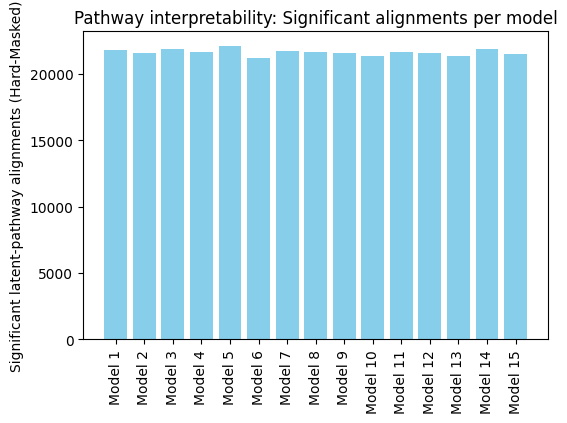

In [37]:
# Bar plot
plt.figure(figsize=(6,4))
plt.bar(range(len(soft_counts)), soft_counts, color='skyblue')
plt.xticks(range(len(soft_counts)), [f'Model {i+1}' for i in range(len(soft_counts))], rotation = 90)
plt.ylabel("Significant latent-pathway alignments (Hard-Masked)")
plt.title("Pathway interpretability: Significant alignments per model")
plt.show()

/tmp/ipython-input-2708421389.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='Correlation', data=df, inner='quartile', palette='Set2')


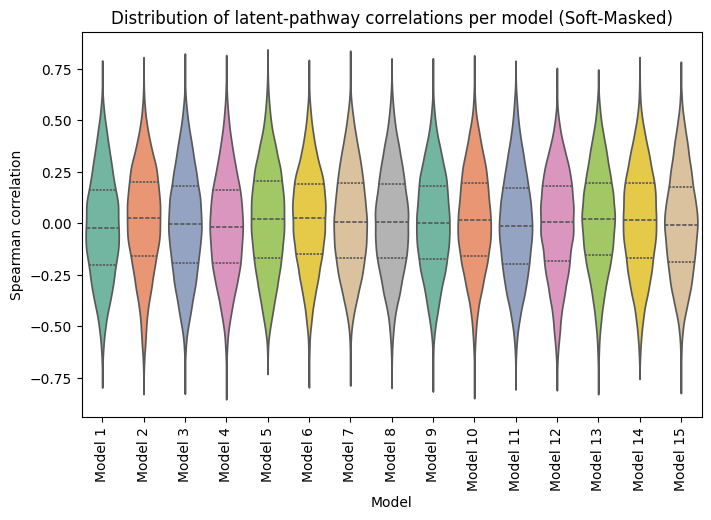

In [38]:
import seaborn as sns
import pandas as pd

# Flatten correlations for all models
df = pd.DataFrame({
    'Correlation': np.concatenate(soft_all_corrs),
    'Model': np.concatenate([
        np.repeat(f'Model {i+1}', len(soft_all_corrs[i])) for i in range(len(soft_all_corrs))
    ])
})

plt.figure(figsize=(8,5))
sns.violinplot(x='Model', y='Correlation', data=df, inner='quartile', palette='Set2')
plt.title("Distribution of latent-pathway correlations per model (Soft-Masked)")

plt.xticks(rotation=90)

plt.ylabel("Spearman correlation")
plt.show()


In [39]:
import matplotlib.pyplot as plt

# Example usage:
hard_counts, hard_top_examples, hard_all_corrs = pathway_interpretability(
    hard_combined_models, X_all_scaled, pathway_mask, alpha=0.05, top_n_examples=5
)




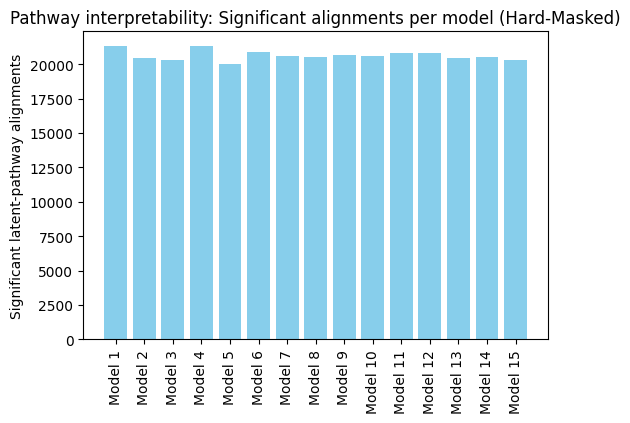

In [42]:
# Bar plot
plt.figure(figsize=(6,4))
plt.bar(range(len(hard_counts)), hard_counts, color='skyblue')
plt.xticks(range(len(hard_counts)), [f'Model {i+1}' for i in range(len(hard_counts))], rotation=90)
plt.ylabel("Significant latent-pathway alignments")
plt.title("Pathway interpretability: Significant alignments per model (Hard-Masked)")
plt.show()

/tmp/ipython-input-2782029454.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='Correlation', data=df, inner='quartile', palette='Set2')


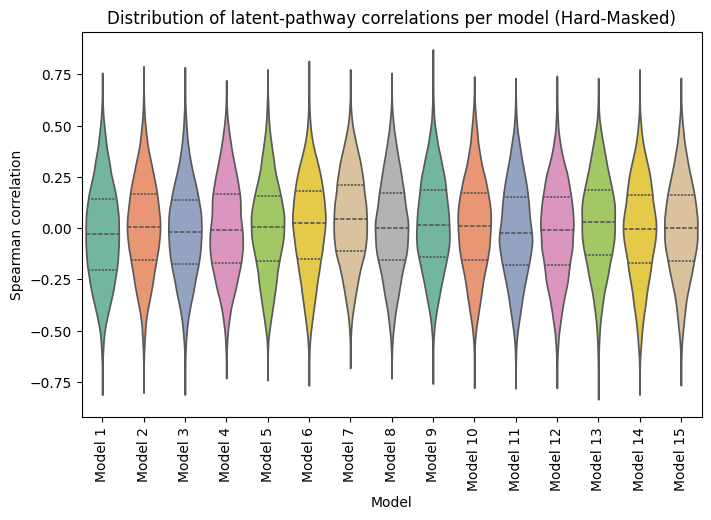

In [45]:
import seaborn as sns
import pandas as pd

# Flatten correlations for all models
df = pd.DataFrame({
    'Correlation': np.concatenate(hard_all_corrs),
    'Model': np.concatenate([
        np.repeat(f'Model {i+1}', len(hard_all_corrs[i])) for i in range(len(hard_all_corrs))
    ])
})

plt.figure(figsize=(8,5))
sns.violinplot(x='Model', y='Correlation', data=df, inner='quartile', palette='Set2')
plt.title("Distribution of latent-pathway correlations per model (Hard-Masked)")
plt.xticks(rotation=90)
plt.ylabel("Spearman correlation")
plt.show()


In [47]:
import matplotlib.pyplot as plt

# Example usage:
baseline_counts, baseline_top_examples, baseline_all_corrs = pathway_interpretability(
    baseline_combined_models, X_all_scaled, pathway_mask, alpha=0.05, top_n_examples=5
)



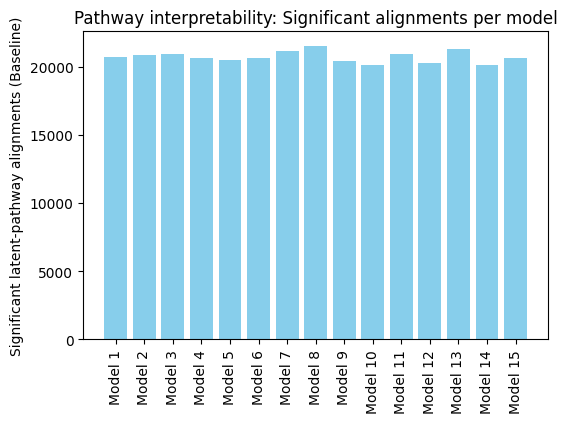

In [50]:
# Bar plot
plt.figure(figsize=(6,4))
plt.bar(range(len(baseline_counts)), baseline_counts, color='skyblue')
plt.xticks(range(len(baseline_counts)), [f'Model {i+1}' for i in range(len(baseline_counts))], rotation=90)
plt.ylabel("Significant latent-pathway alignments (Baseline)")
plt.title("Pathway interpretability: Significant alignments per model")
plt.show()


/tmp/ipython-input-23618840.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='Correlation', data=df, inner='quartile', palette='Set2')


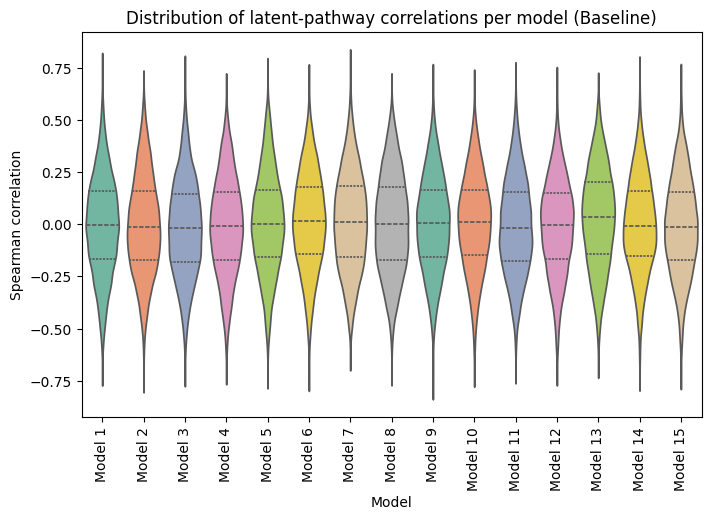

In [51]:
import seaborn as sns
import pandas as pd

# Flatten correlations for all models
df = pd.DataFrame({
    'Correlation': np.concatenate(baseline_all_corrs),
    'Model': np.concatenate([
        np.repeat(f'Model {i+1}', len(baseline_all_corrs[i])) for i in range(len(baseline_all_corrs))
    ])
})

plt.figure(figsize=(8,5))
sns.violinplot(x='Model', y='Correlation', data=df, inner='quartile', palette='Set2')
plt.title("Distribution of latent-pathway correlations per model (Baseline)")
plt.xticks(rotation=90)
plt.ylabel("Spearman correlation")
plt.show()


/tmp/ipython-input-3739851970.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Mask', y='Correlation', data=df, inner='quartile', palette='Set2')


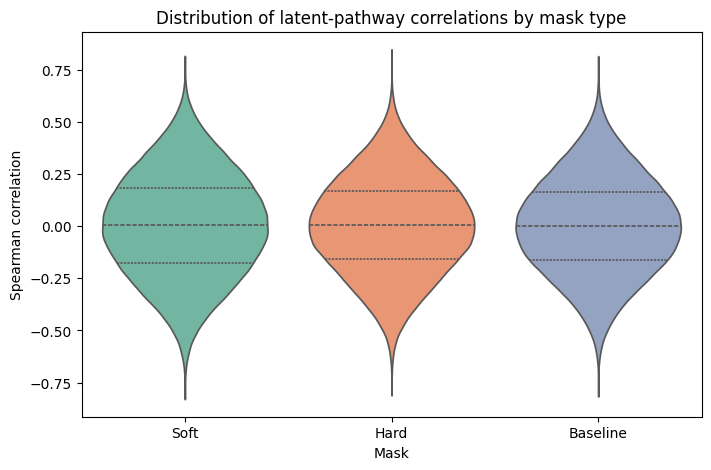

In [52]:
# Combine correlation arrays
all_corrs = soft_all_corrs + hard_all_corrs + baseline_all_corrs
labels = ['Soft']*len(soft_all_corrs) + ['Hard']*len(hard_all_corrs) + ['Baseline']*len(baseline_all_corrs)

# Flatten for violin plot
df = pd.DataFrame({
    'Correlation': np.concatenate(all_corrs),
    'Mask': np.concatenate([
        np.repeat('Soft', len(soft_all_corrs[i])) for i in range(len(soft_all_corrs))
    ] + [
        np.repeat('Hard', len(hard_all_corrs[i])) for i in range(len(hard_all_corrs))
    ] + [
        np.repeat('Baseline', len(baseline_all_corrs[i])) for i in range(len(baseline_all_corrs))
    ])
})

plt.figure(figsize=(8,5))
sns.violinplot(x='Mask', y='Correlation', data=df, inner='quartile', palette='Set2')
plt.title("Distribution of latent-pathway correlations by mask type")
plt.ylabel("Spearman correlation")
plt.show()


/tmp/ipython-input-1486969487.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Mask', y='Num_Significant_Alignments', data=df_melt, ci='sd', palette='Set2')
/tmp/ipython-input-1486969487.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mask', y='Num_Significant_Alignments', data=df_melt, ci='sd', palette='Set2')


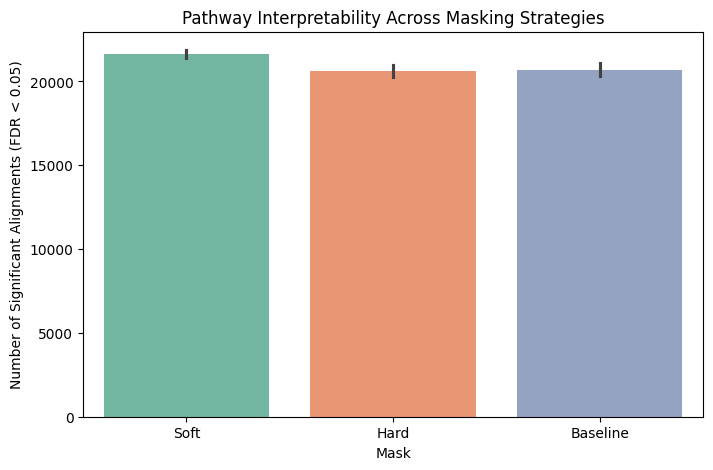

In [53]:

# Combine into a DataFrame
df_counts = pd.DataFrame({
    'Soft': soft_counts,
    'Hard': hard_counts,
    'Baseline': baseline_counts
})

# Melt for plotting
df_melt = df_counts.melt(var_name='Mask', value_name='Num_Significant_Alignments')

plt.figure(figsize=(8,5))
sns.barplot(x='Mask', y='Num_Significant_Alignments', data=df_melt, ci='sd', palette='Set2')
plt.ylabel('Number of Significant Alignments (FDR < 0.05)')
plt.title('Pathway Interpretability Across Masking Strategies')
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks (2)/67960_final_proj_evaluation.ipynb" --output-dir="/content/drive/MyDrive/Colab Notebooks"

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc